<a href="https://colab.research.google.com/github/ndawinata/googleCO/blob/master/CNN_Buah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path_datasets = './drive/MyDrive/Colab Notebooks/Datasets/Buah/train_zip/train/'
path_test = './drive/MyDrive/Colab Notebooks/Datasets/Buah/test_zip/test/'

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS =3

In [ ]:
files = os.listdir(path_datasets)
categories = []
filenames = []

# print(filenames)

for filename in files:
  category = filename.split('_')[0]
  filejpg = filename.split(".")[1]
  if category == 'apple' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(2)
  elif category == 'banana' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(1)
  elif category == 'orange' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
# df['category']

In [ ]:
# df.tail()

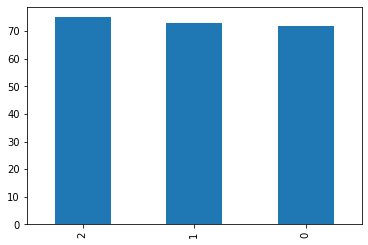

In [ ]:
df['category'].value_counts().plot.bar()

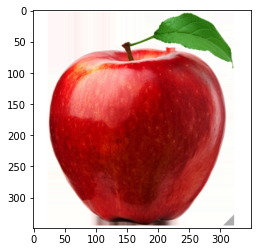

In [ ]:
sample = random.choice(filenames)
image = load_img(path_datasets+sample)
plt.imshow(image)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',padding="same", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

Callbacks

In [ ]:
checkpoint_filepath="/content/model/CNN-Mata-{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}.h5"

grafik_tensor = TensorBoard(log_dir='./Graph')

# model_checkpoint = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# earlystop = EarlyStopping(patience=10)
# to prevent over fitting we will stop the learning after 10 epochs and vall_loss value not decreased
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)
# We will reduce the learning rate when then accuracy not increase for 2 steps

callbacks = [ learning_rate_reduction, grafik_tensor]

In [ ]:
df['category'] = df['category'].replace({0:'orange', 1:'banana', 2:'apel'})

In [ ]:
train_df, validate_df = train_test_split(
    df, 
    test_size=0.20, 
    random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

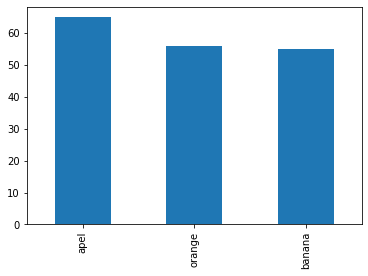

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
# train_df['category'].value_counts().plot.bar()

In [ ]:
# validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 20

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_datasets,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_generator = train_datagen.flow_from_dataframe(
    validate_df,
    path_datasets,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 176 validated image filenames belonging to 3 classes.
Found 44 validated image filenames belonging to 3 classes.


In [ ]:
# example_df = train_df.sample(n=1).reset_index(drop=True)
# example_generator = train_datagen.flow_from_dataframe(
#     example_df, 
#     path_datasets, 
#     x_col='filename',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

See how our generator work

In [ ]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

Fit Model

In [ ]:
!rm -rf Graph/
!rm -rf model/

In [ ]:
epochs=30
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
4/8 [==============>...............] - ETA: 1s - loss: 1.5407 - accuracy: 0.4674

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


8/8 [==============================] - 7s 471ms/step - loss: 1.5537 - accuracy: 0.4175 - val_loss: 1.1043 - val_accuracy: 0.2500
Epoch 2/30
8/8 [==============================] - 3s 398ms/step - loss: 1.1235 - accuracy: 0.3315 - val_loss: 1.1012 - val_accuracy: 0.2250
Epoch 3/30
8/8 [==============================] - 3s 401ms/step - loss: 1.0979 - accuracy: 0.4258 - val_loss: 1.1012 - val_accuracy: 0.2250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
8/8 [==============================] - 3s 402ms/step - loss: 1.0890 - accuracy: 0.3972 - val_loss: 1.1013 - val_accuracy: 0.2250
Epoch 5/30
8/8 [==============================] - 3s 415ms/step - loss: 1.0962 - accuracy: 0.4009 - val_loss: 1.1026 - val_accuracy: 0.2000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/30
8/8 [==============================] - 3s 410ms/step - loss: 1.0874 - accuracy: 0.4229 - val_loss: 1.1012 - val_accuracy: 0.2250
Epoch 7/3

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir Graph/

In [ ]:
files = os.listdir(path_test)
categories = []
filenames = []

# print(filenames)

for filename in files:
  category = filename.split('_')[0]
  filejpg = filename.split(".")[1]
  if category == 'apple' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(2)
  elif category == 'banana' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(1)
  elif category == 'orange' and filejpg == 'jpg':
    filenames.append(filename)
    categories.append(0)

test_df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
nb_samples = test_df.shape[0]

In [ ]:
# test_filenames = os.listdir(path_test)
# test_df = pd.DataFrame({
#     'filename': test_filenames
# })
# nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path_test, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 55 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({0:'orange', 1:'banana', 2:'apel'})

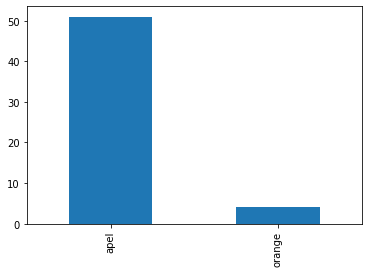

In [ ]:
test_df['category'].value_counts().plot.bar()

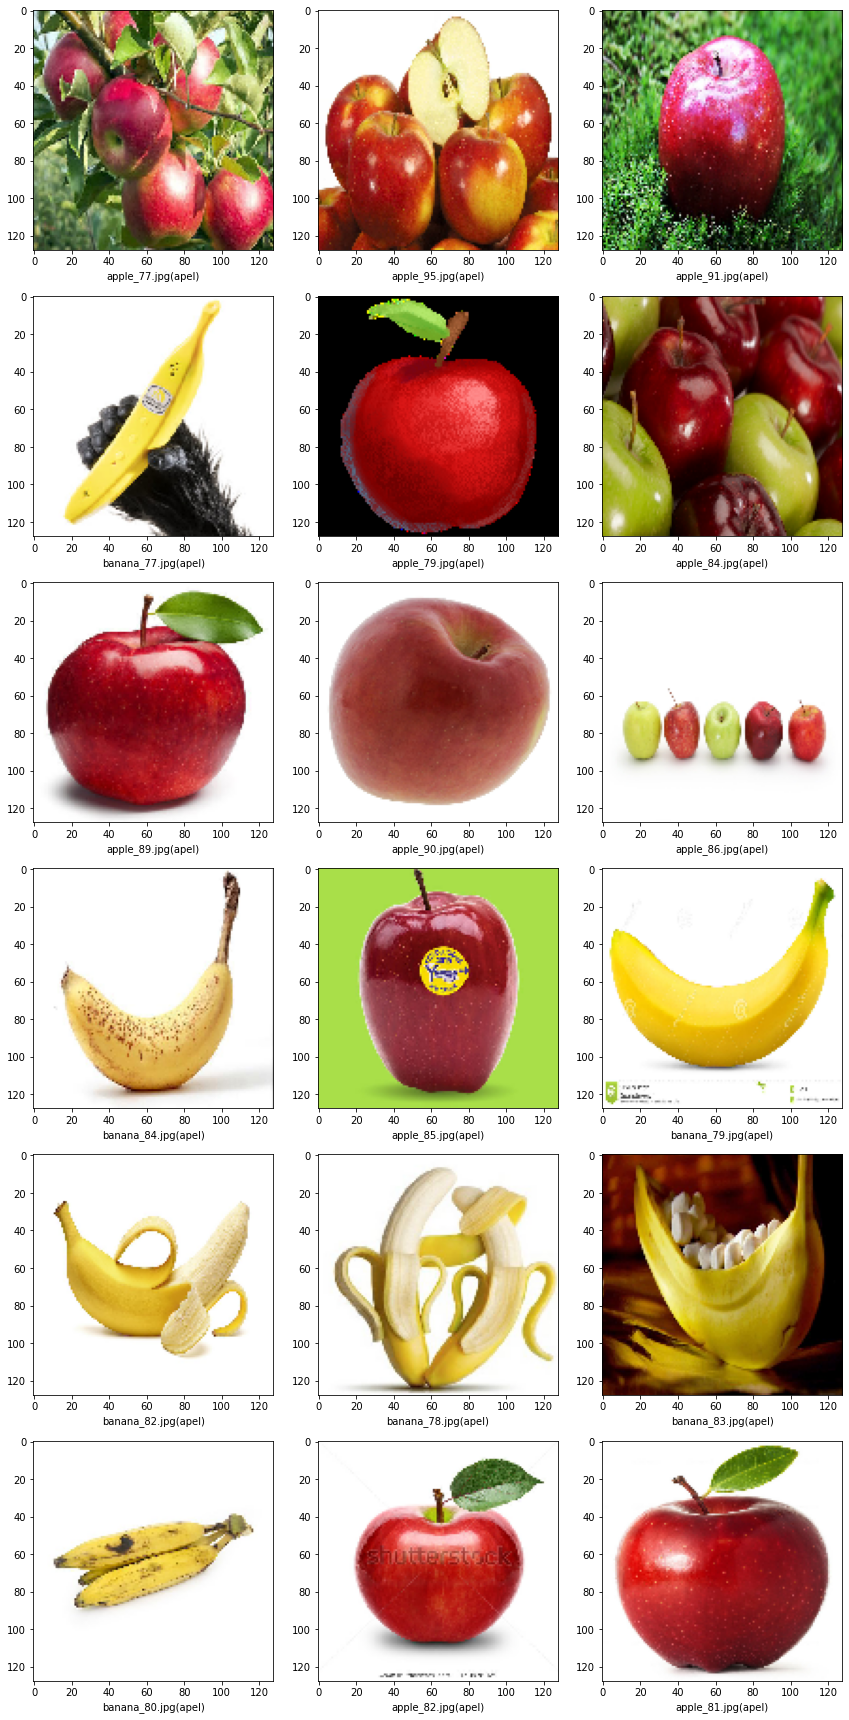

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(path_test+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()